In [1]:
# Initialize packages
import numpy as np
from matplotlib import pyplot as plt

import qcodes as qc
import silq
from silq.instrument_interfaces import Channel
from silq.pulses import SinePulse, TriggerPulse, PulseImplementation, PulseSequence

%matplotlib notebook

<IPython.core.display.Javascript object>

# Introduction

SilQ is a measurement software package that is developed by the Morello group in Sydney.
It utilizes the [QCoDeS measurement software](https://github.com/QCoDeS/Qcodes), and provides added functionality and layers of complexity.
While the actual measurement code is specific to the Morello group, most of the software is kept general and should be usable by other groups with minimal modifications.

At the heart of SilQ is the `Layout` architecture, which translates setup-independent generic measurement code to setup-specific Instrument instructions.
The `Layout` is a meta-instrument that has information about the experimental setup. 
This includes `Instruments`, their channels and the physical connectivity between the channels.
Given a `PulseSequence` with `Pulses` (which are completely setup-independent), the `Layout` can determine which `Instrument` should output each `Pulse`, and distribute them accordingly.
Once distributed, each `Instrument` should be programmed such that it outputs/measures the pulses that it has been given.
This is done by adding an intermediate `Interface` for each `Instrument`.
The `Interface` is used to translate these generic pulses into instructions specific to its `Instrument`.
The `Interface` also reports back to the `Layout` if additional pulses, such as triggering pulses, are necessary, which the `Layout` then passes along to its triggering `Instrument`.

Using this architecture, measurement code can be written that is setup-independent, and can therefore be used in completely different setups without requiring any modifications.
This also greatly simplifies rewiring the setup, or replacing an instrument by another.

To demonstrate the functionality of the Layout architecture, we create a mock setup that consists of three instruments:

1. An acquisition instrument
2. A arbitrary waveform generator (AWG)
3. A triggering instrument that triggers the waveform generator

We then create a Layout that connects these instruments, and show that a generic `PulseSequence` can be converted to an actual measurement.

# Instrument interfaces

Interfaces are the layers between the Layout and Instruments.
They are meant to convert generic instructions from the Layout to actual instructions to the Instruments.
As an example, the Layout calls Interface.setup, after which the Interface should use the pulses in its Interface.pulse_sequence, and convert it to commands to set up the underlying Instrument.

This section sets up the dummy instruments and creates associated interfaces for each of the three instruments.

In [2]:
# Abstract mock interface class
class MockInterface(silq.instrument_interfaces.InstrumentInterface):
    def setup(self, **kwargs):
        # Setup the underlying instrument. Usually here the PulseSequence 
        # is converted to actual Instrument instructions
        pass
    
    def start(self):
        # Start the underlying Instrument
        pass
    
    def stop(self):
        # Stop the underlying Instrument
        pass
    
    def get_final_additional_pulses(self, **kwargs):
        # Specify if additional pulses are necessary (such as a pre-trigger)
        return []

In [3]:
class AcquisitionInterface(MockInterface):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # Define channels (single acquisition channel)
        self._channels = {'ch1': Channel(name='ch1', input=True, 
                                         instrument_name=self.instrument_name())}
        
        # Create a parameter that allows you to choose what channels are acquired
        self.add_parameter('acquisition_channels',
                           parameter_class=qc.instrument.parameter.ManualParameter,
                           initial_value=['ch1'],
                           vals=qc.utils.validators.Anything())
        
        # Add parameter that performs an acquisition
        self.add_parameter('acquisition',
                           names=['ch1_signal'],
                           get_cmd=self._acquisition,
                           shapes=((),))
        
    def setup(self, **kwargs):
        self.sample_rate = 1e3 # kHz
        self.signal = np.zeros(self.pulse_sequence().duration * self.sample_rate)
        self.acquisition.shapes = [(len(self.signal), )]
        
    def receive_pulse(self, pulse):
        # Find start and stop idx for the signal
        start_idx = pulse.t_start * self.sample_rate
        stop_idx = pulse.t_stop * self.sample_rate
        # Create time list for pulse
        t_list = np.linspace(pulse.t_start, pulse.t_stop, stop_idx - start_idx)
        
        # Update self.signal to pulse signal when pulse is active
        self.signal[start_idx:stop_idx] = pulse.get_voltage(t_list)
        
    def _acquisition(self):
        return [self.signal]
    
# Create instrument and associated interface
acquisition_instrument = qc.Instrument(name='acquisition')
acquisition_interface = AcquisitionInterface(instrument_name='acquisition')

In [4]:
class AWGInterface(MockInterface):
    def __init__(self, target_interface, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # Define channels (trigger input, single output)
        self._channels = {'trig_in': Channel(name='trig_in', input_trigger=True,
                                             instrument_name=self.instrument_name()),
                          'ch1': Channel(name='ch1', output=True, 
                                         instrument_name=self.instrument_name())}
        
        # Add pulse implementation for Sine Pulse
        self.pulse_implementations = [
            SineImplementation(
                # Ensure that pulse frequency is not higher than 5 MHz
                pulse_requirements=[('frequency', {'max':5e6})])]
        
        # Since we don't use actual instruments, we pass a target_interface 
        # to which we simulate the sending of pulses
        self.target_interface = target_interface
        
    def receive_pulse(self, pulse):
        # This function is used to simulate receiving a pulse from another instrument
        # As we receive a trigger pulse, we find the corresponding triggered pulse (sine)
        pulse = self.pulse_sequence().get_pulse(t_start=pulse.t_start)
        
        # Send this pulse to the target interface (acquisition interface)
        self.target_interface.receive_pulse(pulse)
        
        
# Create an AWG-specific implementation for the Sine Pulse
class SineImplementation(PulseImplementation, SinePulse):
    def __init__(self, **kwargs):
        PulseImplementation.__init__(self, pulse_class=SinePulse, **kwargs)
    
    def target_pulse(self, pulse, interface, **kwargs):
        # Target the generic pulse to this specific interface
        targeted_pulse = PulseImplementation.target_pulse(
            self, pulse, interface=interface, **kwargs)
        
        # Add a trigger requirement, which is sent back to the Layout
        targeted_pulse.additional_pulses.append(
            TriggerPulse(t_start=pulse.t_start,
                         duration=1e-3,
                         connection_requirements={
                             'input_instrument': interface.instrument_name(),
                             'trigger': True}))
        return targeted_pulse

# Create instrument and associated interface
AWG_instrument = qc.Instrument('AWG')
AWG_interface = AWGInterface(instrument_name='AWG', 
                             target_interface=acquisition_interface)

In [5]:
class TriggerInterface(MockInterface):
    def __init__(self, target_interface, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # Define channels (single output)
        self._channels = {'ch1': Channel(name='ch1', output=True, 
                                         instrument_name=self.instrument_name())}
        
        # Add pulse implementation for Trigger Pulse
        self.pulse_implementations = [
            TriggerImplementation()]
        
        # Since we don't use actual instruments, we pass a target_interface 
        # to which we simulate the sending of pulses
        self.target_interface = target_interface
    
    def start(self):
        # The instrument should start triggering.
        # We simulate this by 'sending' pulses.
        # In reality, pulses are actually applied via hardware connections
        for pulse in self.pulse_sequence():
            self.target_interface.receive_pulse(pulse)


# Create an implementation for the Trigger pulse that is specific to this interface
class TriggerImplementation(PulseImplementation, TriggerPulse):
    def __init__(self, **kwargs):
        PulseImplementation.__init__(self, pulse_class=TriggerPulse, **kwargs)
    
            
# Create a dummy instrument that is supposed to be the triggering instrument
trigger_instrument = qc.Instrument('trigger')
# Create an associated interface, which finds 'trigger_instrument'
# by searching for an instrument with that name
trigger_interface = TriggerInterface(instrument_name='trigger',
                                     target_interface=AWG_interface)

Additional information about Interfaces
- `Interface.channels` contains the channels of its Instrument. This is used when creating connections between interfaces through the Layout.
- `Interface.pulse_implementations` is a list containing implementations of pulses. This is used for two reasons
  - Converting an abstract pulse to targeted instructions for the underlying Instrument. 
    As Instruments are setup in different ways, it should be decided per Instrument how to use a PulseImplementation to perform this conversion (look in existing Interfaces for examples).
  - As a means for the Layout to determine which Instrument a pulse should be directed to. 
    A Layout usually receives abstract pulses containing no information about actual Instruments.
    When the Layout targets an abstract pulse sequence, it checks for each pulse which interface can implement the given pulse.
    It does so by looking at its pulse_implementations.

# Layout

In [6]:
from silq.meta_instruments.layout import Layout

layout = Layout(name='layout', 
                instrument_interfaces=[acquisition_interface, 
                                       AWG_interface, 
                                       trigger_interface])

# Specify the acquisition instrument
layout.acquisition_instrument('acquisition')

layout.acquisition_outputs([('AWG.ch1', 'output')])

In [7]:
layout.add_connection(output_arg='trigger.ch1',
                      input_arg='AWG.trig_in', trigger=True)
layout.add_connection(output_arg='AWG.ch1',
                      input_arg='acquisition.ch1')

Connection{AWG.ch1->acquisition.ch1}()

<IPython.core.display.Javascript object>


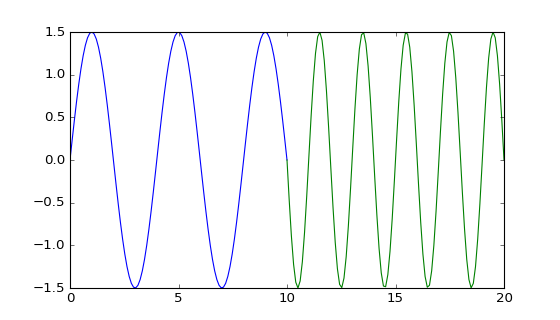

In [8]:
sine_pulse1 = SinePulse(name='sinewave1', t_start=0, duration=10, 
                       frequency=250, power=1.5, phase=0, acquire=True)
sine_pulse2 = SinePulse(name='sinewave2', t_start=10, duration=10, 
                       frequency=500, power=1.5, phase=180, acquire=True)
pulse_sequence = PulseSequence(pulses=[sine_pulse1, sine_pulse2])

# Plot pulses
plt.figure(figsize=(7,4))
for pulse in pulse_sequence:
    t_list = np.linspace(pulse.t_start, pulse.t_stop, 100) # ms
    voltages = pulse.get_voltage(t_list)
    plt.plot(t_list, voltages)

In [9]:
layout.target_pulse_sequence(pulse_sequence)

In [10]:
AWG_interface.pulse_sequence()

PulseSequence with 2 pulses, duration: 20
	SineImplementation(sinewave1, f=0.00 MHz, power=1.5, t_start=0, t_stop=10
		connection: Connection{AWG.ch1->acquisition.ch1}()
		additional_pulses:
		TriggerPulse(None, t_start=0, duration=0.001
			requirements: {'input_instrument': 'AWG', 'trigger': True}))
	SineImplementation(sinewave2, f=0.00 MHz, power=1.5, t_start=10, t_stop=20
		connection: Connection{AWG.ch1->acquisition.ch1}()
		additional_pulses:
		TriggerPulse(None, t_start=10, duration=0.001
			requirements: {'input_instrument': 'AWG', 'trigger': True}))

In [11]:
trigger_interface.pulse_sequence()

PulseSequence with 2 pulses, duration: 20
	TriggerImplementation(None, t_start=0, duration=0.001
		connection: Connection{trigger.ch1->AWG.trig_in}(, trigger)
		requirements: {'input_instrument': 'AWG', 'trigger': True})
	TriggerImplementation(None, t_start=10, duration=0.001
		connection: Connection{trigger.ch1->AWG.trig_in}(, trigger)
		requirements: {'input_instrument': 'AWG', 'trigger': True})

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:34: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


<IPython.core.display.Javascript object>


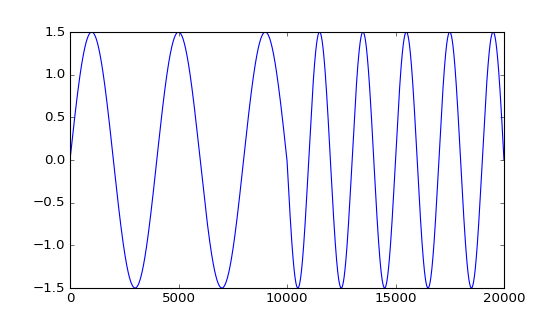

In [24]:
layout.setup()
signals = layout.do_acquisition(return_dict=True)

plt.figure(figsize=(7,4))
plt.plot(signals['acquisition_traces']['output'])